# **LIBRARIES**

When approaching transfer learning, we moved onto VGG at first but our very first attempt was not very promising; besides that, several friends of ours were trying VGG (16 and 19), so we decided to use something different in order to explore the plethora of ready-to-use possibilities provided by Keras.  

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime 
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [ ]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **DATASET**


RGB images of 96x96 pixels.


In [ ]:
def genAugmLayer(seed): 
    return tf.keras.Sequential([
     tfkl.RandomFlip("horizontal_and_vertical"),
     tfkl.RandomRotation(0.5),
     tfkl.RandomZoom( height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3),fill_mode = 'reflect',seed=seed) ])

***'SELECTIVE' AUGMENTATION (x2)***


In [ ]:

imbalClasses = tf.keras.utils.image_dataset_from_directory( 
    '../input/correctedbal',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    subset = 'training',
    validation_split=0.2,
    seed=seed,
)

data_augmentation1 = genAugmLayer(17) 
dataAugmImbal = imbalClasses.map(lambda x , y : (data_augmentation1(x), y)) 
data_augmentation2 = genAugmLayer(271) 
dataAugmImbal = dataAugmImbal.concatenate(imbalClasses.map(lambda x , y : (data_augmentation2(x), y))) #double samples of classes 1 and 6 

Found 414 files belonging to 8 classes.
Using 332 files for training.


We tried this 'fancy' way of doing augmentation. We generated two augmentation layers to be fed with our images in order to use different seeds and obtain, hopefully, different augmented samples to concatenate to our training dataset. Basically, we wanted only the imbalanced classes to be augmented at first in order to try to rebalance the dataset and bring up the F1 scores of those classes as performance were pretty poor for minority classes.  

The 'imbalClasses' object contains only samples from Species 1 and 6.
We used the very same seed used for splitting the complete training set for splitting this one.

Splitting such a dataset might seem pointless and even harmful because 
we seem to be throwing away data which could be used by our model. But we cannot let validation set and training set overlap, otherwise model assessment is just highly biased and unreliable. 

At first we were skeptical about this strategy, which is somehow 'naive' but we think it may have helped to bring up classes 1 and 6 F1 scores, so we stuck to it. 

***UNIVERSAL AUGMENTATION***

In [ ]:
datapath = '../input/annhw1/training_data_final'
training_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='training'
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)


#-------------WEIGHTS ----------------------------------
labels = np.concatenate([y for x, y in training_set], axis=0) 
class_weights = class_weight.compute_class_weight(class_weight='balanced' ,classes = [i for i in range(8)] , y = np.argmax(labels, axis=-1) ) 
weights = dict(enumerate(class_weights)) 
print(weights)
#-------------------------------------------------------

Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.
{0: 2.393581081081081, 1: 0.8296252927400468, 2: 0.8923173803526449, 3: 0.843452380952381, 4: 0.8162442396313364, 5: 2.012784090909091, 6: 0.8032879818594104, 7: 0.9060102301790282}


We used sklearn.utils.class_weight to compute weights to weigh samples from different classes. In the very first training round, however, we did not use them to weight the loss function, we kept them for later use.

***RESCALING***

In [ ]:
data_augmentation = genAugmLayer(89)
training_set = training_set.concatenate(training_set.map(lambda x , y : (data_augmentation(x), y)) ) #total augm
training_set = training_set.concatenate(dataAugmImbal)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

# **Transfer Learning**

In [ ]:
initial_time = datetime.datetime.now()
input_shape = (96, 96, 3)
epochs = 90

In [ ]:
training_set = training_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x), y))
validation_set = validation_set.map(lambda x,y: (tf.keras.applications.inception_v3.preprocess_input(x),y))

In [ ]:
supernet = tf.keras.applications.inception_v3.InceptionV3( include_top=False, weights='imagenet')
supernet.trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
#ARCHITECTURE
input_layer = tfkl.Input(input_shape)
x = tfkl.Resizing(height = 299, width = 299, interpolation = 'bicubic' )(input_layer)
x = supernet(x)
x = tfkl.GlobalAveragePooling2D()(x) 
x = tfkl.Dropout(rate=0.3)(x)
x = tfkl.Dense(units=128, name='Dense3', kernel_initializer=tfk.initializers.HeUniform(seed),  activation='relu')(x)
x = tfkl.Dropout(rate=0.3)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)
    
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')
#default learning rate: it might be too high

In [ ]:
from datetime import datetime
def create_folders_and_callbacks(model_name):
    callbacks = []
    # Early Stopping
    # --------------
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) #tuning point
    callbacks.append(es_callback)
    return callbacks

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Dense3 (Dense)               (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

We only unfreeze a few layers of the Features Extraction Network. 
In particular, we tried to unfreeze only the starting and ending part of the network, even though most of the trainable parameters we unlocked seemed to be just in the first part of the architecture. 

In [ ]:
for i, layer in enumerate(model.get_layer('inception_v3').layers[:-1]):
    layer.trainable=False

for i, layer in enumerate(model.get_layer('inception_v3').layers[:15]):
    layer.trainable=True
    
for i, layer in enumerate(model.get_layer('inception_v3').layers[-15:-1]):
    layer.trainable = True

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Dense3 (Dense)               (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [ ]:
callbacks = create_folders_and_callbacks(model_name='myModel_TESTING')

# we did not use class weights for training 
history = model.fit(
    x = training_set,
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks
).history

Epoch 1/90
200/200 [==============================] - 133s 491ms/step - loss: 1.5105 - accuracy: 0.4520 - val_loss: 72.6934 - val_accuracy: 0.0833
Epoch 2/90
200/200 [==============================] - 92s 461ms/step - loss: 1.1783 - accuracy: 0.5660 - val_loss: 7.4090 - val_accuracy: 0.2274
Epoch 3/90
200/200 [==============================] - 92s 462ms/step - loss: 0.9633 - accuracy: 0.6530 - val_loss: 3.0655 - val_accuracy: 0.3489
Epoch 4/90
200/200 [==============================] - 92s 461ms/step - loss: 0.8104 - accuracy: 0.7091 - val_loss: 2.2846 - val_accuracy: 0.4520
Epoch 5/90
200/200 [==============================] - 92s 460ms/step - loss: 0.7112 - accuracy: 0.7554 - val_loss: 1.7562 - val_accuracy: 0.5127
Epoch 6/90
200/200 [==============================] - 92s 460ms/step - loss: 0.5809 - accuracy: 0.7967 - val_loss: 2.3572 - val_accuracy: 0.5353
Epoch 7/90
200/200 [==============================] - 92s 460ms/step - loss: 0.4935 - accuracy: 0.8247 - val_loss: 1.7385 - val_

In [ ]:
final_time = datetime.now()
print("Training took %s" % (final_time - initial_time))

Training took 1:59:00.069460


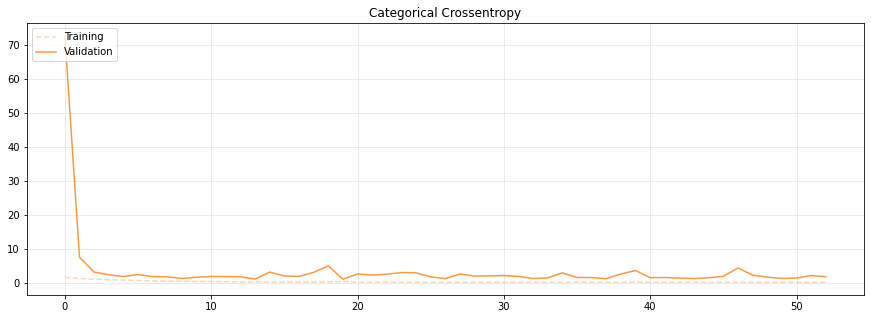

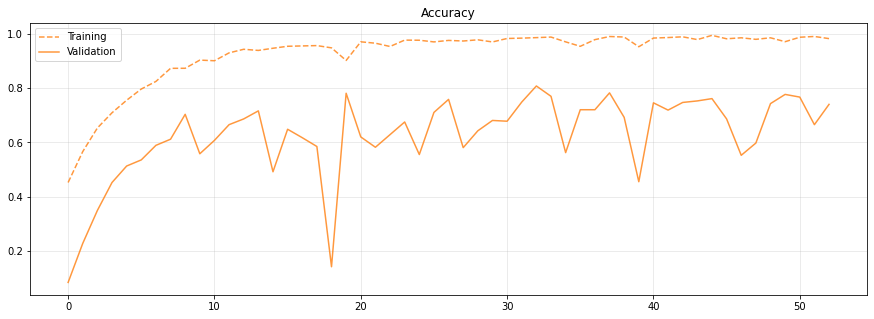

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save("models/myModel")

23/23 [==============================] - 3s 128ms/step - loss: 1.1609 - accuracy: 0.8079
{'loss': 1.160852313041687, 'accuracy': 0.8079096078872681}
Accuracy: 0.8079
Precision: 0.7935
Recall: 0.7886
F1: 0.7872
F1 (per class):
[0.50632911 0.79425837 0.87242798 0.82722513 0.82568807 0.84090909
 0.9        0.73076923]
WORST CLASS: Species: 1


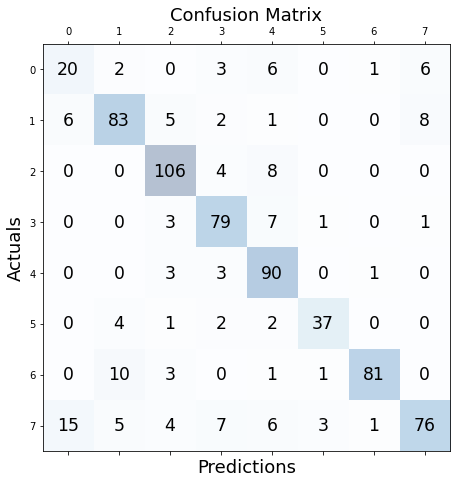

In [ ]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

DATASET_EVAL = validation_set
labels = np.concatenate([y for x, y in DATASET_EVAL], axis=0) 
predictions = model.predict(validation_set) 

assert len(labels) == len(predictions)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1_classes = f1_score(np.argmax(labels, axis=-1), np.argmax(predictions, axis=-1), average=None)

print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))
print('F1 (per class):')
print(f1_classes)

print('WORST CLASS: Species:', np.argmin(f1_classes)+1)

# Plot the confusion matrix
ig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

As you can see, validation score was promising as far as accuracy is concerned but F1 score of the first class was very low. So we submitted our model to give it a shot and we got circa 80% of accuracy (overall). However, since performance were pretty similar to our validation score we thought that we were moving the 'right' direction and that we could keep using this pretty 'fancy' data augmentation strategy to proceed increasing the number of trainable layers in order to improve features extraction.  